In [1]:
import stlearn as st
import scanpy as sc
import pandas as pd
import re
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix
import anndata as ad
import seaborn as sns
import harmonypy as hm
from matplotlib import pyplot as plt
from stlearn.spatials.clustering import localization

import gseapy as gp
from matplotlib.colors import LogNorm


plt.rcParams['figure.figsize'] = [6, 6]

C:\Users\masmel\AppData\Local\anaconda3\envs\stlearn2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\masmel\AppData\Local\anaconda3\envs\stlearn2\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\masmel\AppData\Local\anaconda3\envs\stlearn2\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\masmel\AppData\Local\anaconda3\envs\stlearn2\lib\site-packages\stlearn\tools\microenv\cci\het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=Tr

# Helping functions 

In [2]:
"""
The whole chunk below is to fix the following issue:
https://github.com/BiomedicalMachineLearning/stLearn/issues/243#issuecomment-1657823079
"""

from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import matplotlib
import numpy as np
import networkx as nx
import random
from stlearn._compat import Literal
from typing import Optional, Union
from anndata import AnnData
import warnings
import io
from copy import deepcopy
from stlearn.utils import _read_graph



def tree_plot_new(
    adata: AnnData,
    library_id: str = None,
    figsize: Union[float, int] = (10, 4),
    data_alpha: float = 1.0,
    use_label: str = "louvain",
    spot_size: Union[float, int] = 50,
    fontsize: int = 6,
    piesize: float = 0.15,
    zoom: float = 0.1,
    name: str = None,
    output: str = None,
    dpi: int = 180,
    show_all: bool = False,
    show_plot: bool = True,
    copy: bool = False,
) -> Optional[AnnData]:

    
    """\
    Hierarchical tree plot represent for the global spatial trajectory inference.

    Parameters
    ----------
    adata
        Annotated data matrix.
    library_id
        Library id stored in AnnData.
    use_label
        Use label result of cluster method.
    figsize
        Change figure size.
    data_alpha
        Opacity of the spot.
    fontsize
        Choose font size.
    piesize
        Choose the size of cropped image.
    zoom
        Choose zoom factor.
    show_all
        Show all cropped image or not.
    show_legend
        Show legend or not.
    dpi
        Set dpi as the resolution for the plot.
    copy
        Return a copy instead of writing to adata.
    Returns
    -------
    Nothing
    """

    G = _read_graph(adata, "PTS_graph")

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    for node in G.nodes:
        if node == 9999:
            break
        tmp_img = _generate_image_new(
            adata,
            library_id,
            sub_cluster=node,
            zoom=zoom,
            spot_size=spot_size,
            fontsize=fontsize,
            show_all=show_all,
            use_label=use_label,
        )

        G.nodes[node]["image"] = tmp_img

    # plt.rcParams['figure.dpi'] = dpi
    pos = hierarchy_pos_new(G, 9999)
    fig = plt.figure(figsize=figsize)
    a = plt.subplot(111)

    a.axis("off")
    nx.draw_networkx_edges(
        G,
        pos,
        ax=a,
        arrowstyle="-",
        edge_color="#ADABAF",
        connectionstyle="angle3,angleA=0,angleB=90",
    )
    trans = a.transData.transform
    trans2 = fig.transFigure.inverted().transform

    p2 = piesize / 2

    for n in G:
        if n == 9999:
            xx, yy = trans(pos[n])  # figure coordinates
            xa, ya = trans2((xx, yy))  # axes coordinates
            a = plt.axes([xa - p2, ya - p2, piesize, piesize])
            a.axis("off")
            a.text(
                0.5,
                0.9,
                "Pseudoroot",
                horizontalalignment="center",
                verticalalignment="center",
                transform=a.transAxes,
                bbox=dict(facecolor="#F9F9F9", boxstyle="round", edgecolor="#D1D1D1"),
            )
            break

        xx, yy = trans(pos[n])  # figure coordinates
        xa, ya = trans2((xx, yy))  # axes coordinates
        a = plt.axes([xa - p2, ya - p2, piesize, piesize])

        subset = adata.obs[adata.obs["sub_cluster_labels"] == str(n)]
        color = adata.uns[use_label + "_colors"][int(subset[use_label][0])]

        a.text(
            0.5,
            1.2,
            str(n),
            horizontalalignment="center",
            verticalalignment="center",
            transform=a.transAxes,
            color="black",
            fontsize=fontsize,
            zorder=3,
            bbox=dict(facecolor=color, boxstyle="round"),
        )
        # a.set_aspect('equal')
        a.axis("off")
        a.imshow(G.nodes[n]["image"])
        # plt.rcParams.update(plt.rcParamsDefault)

    if name is None:
        name = use_label

    if output is not None:
        fig.savefig(output + "/" + name, dpi=dpi, bbox_inches="tight", pad_inches=0)

    if show_plot == True:
        plt.show()

def _generate_image_new(
    adata,
    library_id,
    sub_cluster,
    zoom=10,
    spot_size=100,
    fontsize=6,
    dpi=96,
    use_label="louvain",
    data_alpha=1,
    show_all=False,
):

    # plt.rcParams['axes.linewidth'] = 4

    # plt.rcParams['axes.edgecolor'] = "#D1D1D1"

    subset = adata.obs[adata.obs["sub_cluster_labels"] == str(sub_cluster)]
    base = subset[["imagecol", "imagerow"]].values
    if len(base) < 25:
        zoom = zoom * 20
        spot_size = spot_size * 3
    elif len(base) > 2000:
        zoom = zoom / 4
        spot_size = spot_size / 5
    x = base[:, 0]
    y = base[:, 1]
    # plt.rcParams['figure.dpi'] = 300

    fig2, ax2 = plt.subplots()

    for axis in ["top", "bottom", "left", "right"]:
        ax2.spines[axis].set_linewidth(0.5)
        ax2.spines[axis].set_color("#D1D1D1")

    color = adata.uns[use_label + "_colors"][int(subset[use_label][0])]

    image = adata.uns["spatial"][library_id]["images"][
        adata.uns["spatial"][library_id]["use_quality"]
    ]

    ax2.imshow(image, alpha=1)
    ax2.scatter(x, y, s=spot_size, alpha=data_alpha, edgecolor="none", c=color)

    # ax2.axis('off')
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])

    try:
        ptp_bound = np.array(base).ptp(axis=0)
    except:
        print(base)

    m = 0
    n = 0
    if np.abs((y.min() - ptp_bound[1] * zoom) - (y.max() + ptp_bound[1] * zoom)) < 50:
        m = m + 50
    elif np.abs((x.min() - ptp_bound[1] * zoom) - (x.max() + ptp_bound[1] * zoom)) < 50:
        n = n + 50
    ax2.set_xlim(x.min() - ptp_bound[0] * zoom - n, x.max() + ptp_bound[0] * zoom - n)

    ax2.set_ylim(y.min() - ptp_bound[1] * zoom - m, y.max() + ptp_bound[1] * zoom + m)

    plt.gca().invert_yaxis()
    if show_all:
        plt.show()
    buf = io.BytesIO()
    fig2.savefig(
        buf,
        format="png",
        dpi=dpi,
        transparent=True,
        bbox_inches="tight",
        pad_inches=0.1,
    )
    buf.seek(0)
    pil_img = deepcopy(Image.open(buf))
    plt.close(fig2)
    return pil_img

def hierarchy_pos_new(G, root=None, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):

    """
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.
    Licensed under Creative Commons Attribution-Share Alike

    If the graph is a tree this will return the positions to plot this in a
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch
    - if the tree is directed and this is not given,
      the root will be found and used
    - if the tree is directed and this is given, then
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given,
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    """
    if not nx.is_tree(G):
        raise TypeError("cannot use hierarchy_pos_new on a graph that is not a tree")

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(
                iter(nx.topological_sort(G))
            )  # allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos_new(
        G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None
    ):
        """
        see hierarchy_pos_new docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        """

        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos_new(
                    G,
                    child,
                    width=dx,
                    vert_gap=vert_gap,
                    vert_loc=vert_loc - vert_gap,
                    xcenter=nextx,
                    pos=pos,
                    parent=root,
                )
        return pos

    return _hierarchy_pos_new(G, root, width, vert_gap, vert_loc, xcenter)




In [3]:
"""
There are two bugs in their code that I found. replace_with_dict and selection_sort are just support functions that are needed to run the other
two functions. Consider reporting this as a bug as it would clean my code and their code would actually be the same as they present in the paper
"""

def replace_with_dict(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()), dtype=object)
    v = np.array(list(dic.values()), dtype=object)

    out = np.zeros_like(ar)
    for key, val in zip(k, v):
        out[ar == key] = val
    return out
    
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

def store_available_paths_new(adata, threshold, use_label, max_nodes, pseudotime_key):

    """
    This function is originally incompatiple with their function pseudotimespace_global.
    https://github.com/BiomedicalMachineLearning/stLearn/blob/master/stlearn/spatials/trajectory/global_level.py line 198 they use median.
    Thus, I changed .max() to .median() in the first for loop.
    """
    
    # Read original PAGA graph
    G = nx.from_numpy_array(adata.uns["paga"]["connectivities"].toarray())
    edge_weights = nx.get_edge_attributes(G, "weight")
    G.remove_edges_from((e for e, w in edge_weights.items() if w < threshold))

    H = G.to_directed()

    # Calculate pseudotime for each node
    node_pseudotime = {}

    for node in H.nodes:
        node_pseudotime[node] = adata.obs.query(use_label + " == '" + str(node) + "'")[
            pseudotime_key
        ].median() 

    # Force original PAGA to directed PAGA based on pseudotime
    edge_to_remove = []
    for edge in H.edges:
        if node_pseudotime[edge[0]] - node_pseudotime[edge[1]] > 0:
            edge_to_remove.append(edge)
    H.remove_edges_from(edge_to_remove)

    # Extract all available paths
    all_paths = {}

    for source in H.nodes:
        for target in H.nodes:
            paths = nx.all_simple_paths(H, source=source, target=target)
            for i, path in enumerate(paths):
                if len(path) < max_nodes:
                    all_paths[str(i) + "_" + str(source) + "_" + str(target)] = path

    adata.uns["available_paths"] = all_paths
    print(
        "All available trajectory paths are stored in adata.uns['available_paths'] with length < "
        + str(max_nodes)
        + " nodes"
    )

    return(H)


def pseudotime_new(
    adata: AnnData,
    use_label: str = None,
    eps: float = 20,
    threshold: float = 0.01,
    threshold_spots: int = 5,
    reverse: bool = False,
    pseudotime_key: str = "dpt_pseudotime",
    max_nodes: int = 4,
    copy: bool = False,
) -> Optional[AnnData]:

    """\

    They have a bug in processing the data. The functions localization, neighbors, paga and diffmap are run in incorrect order, eventually causing
    that diffmap is not called properly. 
    https://github.com/BiomedicalMachineLearning/stLearn/blob/master/stlearn/spatials/trajectory/pseudotime.py

 
    Perform pseudotime analysis.

    Parameters
    ----------
    adata
        Annotated data matrix.
    use_label
        Use label result of cluster method.
    eps
        The maximum distance between two samples for one to be considered as
        in the neighborhood of the other. This is not a maximum bound on the
        distances of points within a cluster. This is the most important DBSCAN
        parameter to choose appropriately for your data set and distance function.
    threshold
        Threshold to find the significant connection for PAGA graph.
    radius
        radius to adjust data for diffusion map
    method
        method to adjust the data.
    use_sme
        Use adjusted feature by SME normalization or not
    reverse
        Reverse the pseudotime score
    pseudotime_key
        Key to store pseudotime
    max_nodes
        Maximum number of node in available paths
    copy
        Return a copy instead of writing to adata.
    Returns
    -------
    Anndata
    """

    # Get connection matrix
    cnt_matrix = adata.uns["paga"]["connectivities"].toarray()
    
    # Filter by threshold
    
    cnt_matrix[cnt_matrix < threshold] = 0.0
    cnt_matrix = pd.DataFrame(cnt_matrix)
    
    # Mapping louvain label to subcluster
    
    #from stlearn.spatials.clustering import localization
    
    #localization(adata, use_label=use_label, eps=eps)
    cat_ind = adata.uns[use_label + "_index_dict"]
    
    split_node = {}
    for label in adata.obs[use_label].unique():
        meaningful_sub = []
        for i in adata.obs[adata.obs[use_label] == label][
            "sub_cluster_labels"
        ].unique():
            if (
                len(adata.obs[adata.obs["sub_cluster_labels"] == str(i)])
                > threshold_spots
            ):
                meaningful_sub.append(i)
    
        split_node[cat_ind[label]] = meaningful_sub
    
    adata.uns["threshold_spots"] = threshold_spots
    adata.uns["split_node"] = split_node
    
    # Replicate louvain label row to prepare for subcluster connection
    # matrix construction
    replicate_list = np.array([])
    for i in range(0, len(cnt_matrix)):
        replicate_list = np.concatenate(
            [replicate_list, np.array([i] * len(split_node[i]))]
        )
    
    # Connection matrix for subcluster
    cnt_matrix = cnt_matrix.loc[replicate_list.astype(int), replicate_list.astype(int)]
    
    # Replace column and index
    cnt_matrix.columns = replace_with_dict(cnt_matrix.columns, split_node)
    cnt_matrix.index = replace_with_dict(cnt_matrix.index, split_node)
    
    # Sort column and index
    cnt_matrix = cnt_matrix.loc[
        selection_sort(np.array(cnt_matrix.columns)),
        selection_sort(np.array(cnt_matrix.index)),
    ]
    
    # Create a connection graph of subclusters
    G = nx.from_pandas_adjacency(cnt_matrix)
    G_nodes = list(range(len(G.nodes)))
    
    node_convert = {}
    for pair in zip(list(G.nodes), G_nodes):
        node_convert[pair[1]] = pair[0]
    
    adata.uns["global_graph"] = {}
    adata.uns["global_graph"]["graph"] = nx.to_scipy_sparse_array(G)
    adata.uns["global_graph"]["node_dict"] = node_convert
    
    # Create centroid dict for subclusters
    from sklearn.neighbors import NearestCentroid
    
    clf = NearestCentroid()
    clf.fit(adata.obs[["imagecol", "imagerow"]].values, adata.obs["sub_cluster_labels"])
    centroid_dict = dict(zip(clf.classes_.astype(int), clf.centroids_))
    
    def closest_node(node, nodes):
        nodes = np.asarray(nodes)
        dist_2 = np.sum((nodes - node) ** 2, axis=1)
        return np.argmin(dist_2)
    
    for cl in adata.obs["sub_cluster_labels"].unique():
        cl_points = adata.obs[adata.obs["sub_cluster_labels"] == cl][
            ["imagecol", "imagerow"]
        ].values
        new_centroid = cl_points[closest_node(centroid_dict[int(cl)], cl_points)]
        centroid_dict[int(cl)] = new_centroid
    
    adata.uns["centroid_dict"] = centroid_dict
    centroid_dict = {int(key): centroid_dict[key] for key in centroid_dict}
    
    # Running diffusion pseudo-time
    sc.tl.dpt(adata)
    
    if reverse:
        adata.obs[pseudotime_key] = 1 - adata.obs[pseudotime_key]

    H = store_available_paths_new(adata, threshold, use_label, max_nodes, pseudotime_key)
    
    
    return H
    
    
 
    





In [4]:
def apply_mapping(lst, mapping):
    """ 
    Function to remap between the lst of subclusters to original clusters 
    """
    result = []
    for item in lst:
        for key, values in mapping.items():
            if item in values:
                result.append(key)
                break
    return result
    
#Support functions to run the code
def path_importance(G, path):
    """
    Compute the importance of a path as a minimum edge importance in the path through the PAGA graph
    """
    # Initialize the importance as infinity
    importance = float('inf')
    # Iterate over the path
    for i in range(len(path) - 1):
        # Get the weight of the current edge
        weight = G[path[i]][path[i+1]]['weight']
        
        # Update the importance if the current weight is smaller
        if weight < importance:
            importance = weight
    
    # Return the importance of the path
    return importance


def preprocess(adata, louvain_resolution, n_top_genes = 2000):
    """
    Preprocess the data. Be carefull about the order in which diffmap is called relative to other functions
    """
    sc.pp.filter_genes(adata,min_cells=3)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    # Keep raw data
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
    #sc.pp.highly_variable_genes(adata)

    sc.pp.scale(adata)
    
    st.em.run_pca(adata, random_state=0)
    
    sc.pp.neighbors(adata, use_rep="X_pca", random_state=0)
    
    
    sc.tl.diffmap(adata, n_comps = 15, random_state=0)
    sc.pp.neighbors(adata, use_rep="X_diffmap", random_state=0)
    
    
    st.tl.clustering.louvain(adata,random_state=0, resolution = louvain_resolution)

    return adata

def rename_clusters(adata, obs_name, threshold):
    """
    Rename the clusters to fix their bug that the clusters need to be called 0,1,2,3,...
    """
    counts = adata.obs[obs_name].value_counts()
    filtered_categories = counts[counts >= threshold].index
    adata = adata[adata.obs[obs_name].isin(filtered_categories)]
    
    cats = np.array(adata.obs[obs_name].cat.categories)
    rename = list(np.array(range(max(cats.astype(int))+1, max(cats.astype(int)) + len(cats) + 1 )).astype(str))
    adata.obs[obs_name] = adata.obs[obs_name].replace(cats, rename)
    cats = np.array(adata.obs[obs_name].cat.categories)
    rename = list(np.array(range(len(cats))).astype(str))
    adata.obs[obs_name] = adata.obs[obs_name].replace(cats, rename)
    
    return adata

def find_reasonable_paths(G):
    """
    Find all paths that start at 9999 and end on the leave of the tree plot
    Find nodes with out-degree of zero, which are leaves in a directed graph
    """
    leaves = [node for node in G.nodes() if G.out_degree(node) == 0]

    # Find all paths from each leave
    all_paths = []
    for node in leaves:
        paths = nx.single_target_shortest_path(G, node)[9999]
        paths = [str(i) for i in paths] # Change to string
        all_paths.extend([paths])

    return all_paths

def find_longest_paths(adata): 
    """
    Filter only those paths that correspond to the longest possible, 
    e.g. with two paths 0-1-2-3 and 0-1-2; I would only keep 0-1-2-3 as the latter is only subset of it
    We need this function as find_reasonable_paths is called for every cluster combination and thus
    leaves in one scenarion might correspond to the second last layer in the longer path
    
    Difference to find_longest_paths_v2: 
    If there are 0-1-3 and 0-1-2-3 then I keep the both as it is not a direct subset. 
    """
    # Identify the longest paths
    longest_paths = adata.uns["available_paths"].copy()
    for key1, list1 in adata.uns["available_paths"].items():
        for key2, list2 in adata.uns["available_paths"].items():
            if list1 != list2 and any(list1 == list2[i:i+len(list1)] for i in range(len(list2) - len(list1) + 1)):
                if key1 in longest_paths:
                    del longest_paths[key1]
                    
            if list1 != list2 and any(list1 == list2[1:i] for i in range(len(list2) - len(list1) + 1)):
                if key1 in longest_paths:
                    del longest_paths[key1]
    
    return(longest_paths)

def find_longest_paths_v2(adata): 
    """
    Filter only those paths that correspond to the longest possible, 
    e.g. with two paths 0-1-2-3 and 0-1-2; I would only keep 0-1-2-3 as the latter is only subset of it
    We need this function as find_reasonable_paths is called for every cluster combination and thus
    leaves in one scenarion might correspond to the second last layer in the longer path
    
    Difference to find_longest_paths: 
    Note: If there are 0-1-3 and 0-1-2-3 then I keep only 0-1-2-3 as 0-1-3 is considered to be a subset 
    """
    # Identify the longest paths
    longest_paths = adata.uns["available_paths"].copy()
    for key1, list1 in adata.uns["available_paths"].items():
        for key2, list2 in adata.uns["available_paths"].items():
            if list1 != list2 and set(list1).issubset(set(list2)):
                if key1 in longest_paths:
                    del longest_paths[key1]

    return(longest_paths)


def summarize_branch(adata, use_label, H):
    """ 
    This is for the plot purposes, we summarize the branch by getting the counts of each subclone for every branch
    """
    correlated_genes = list()

    branch_keys = list(filter(lambda x: x.startswith('branch'), adata.uns))
    branch_keys = [branch for branch in branch_keys if len(branch.split('_')) > 3]
    cats = list(use_label + '_' + np.array(adata.obs[use_label].cat.categories))
    #branch_summary = pd.DataFrame(index = branch_keys, columns = ['path_length', 'importance', 'pseudotime'] + cats)
    branch_summary = pd.DataFrame(index = branch_keys, columns = ['path_length', 'importance'] + cats)
    
    for branch in branch_keys:
        
        subclusters = branch.split('_')[1:]
    
        path = apply_mapping(subclusters[1:], adata.uns['split_node'])
        branch_summary['path_length'][branch] = len(path)
        branch_summary['importance'][branch] = path_importance(H, path)
        #branch_summary['pseudotime'][branch] = adata.obs['dpt_pseudotime'][adata.obs['sub_cluster_labels'].isin(subclusters)]

        subclusters_counts = adata.obs[use_label][adata.obs['sub_cluster_labels'].isin(subclusters)].value_counts()
        subclusters_counts = {category: count for category, count in subclusters_counts.items()}
        # Convert to string
        for cat in adata.obs[use_label].cat.categories:
            branch_summary[use_label + '_' + cat][branch] = subclusters_counts[cat]

    return branch_summary


def enrichment_analysis(adata, gene_set):
    """
    Enchichment analysis for each branch in adata
    """
    import gseapy as gp
    names = gp.get_library_name()
    BG_genes = adata.var_names
    #branch_keys = [key for key in adata.uns.keys() if key.startswith('branch')]
    branch_keys = list(filter(lambda x: x.startswith('branch'), adata.uns))
    branch_keys = [branch for branch in branch_keys if len(branch.split('_')) > 3]
    
    
    from IPython.display import display
    import ast
    
    pathway_enrichment = {}
    
    for score_dir in ['up' ,'down', 'abs']:
        print(score_dir)
    
        GO_enrichemnt = list()
    
        for branch in branch_keys:
            print(branch)
        
        #for score_dir in ['up' ,'down']: #Top_GPs_summary['comparison_pair'].unique() ['GG4 Cribriform vs Reference', 'GG4 Cribriform vs Benign']
            subclusters = branch.split('_')[1:]
            
            Gene_programs_trajectory = adata.uns[branch]
            
            # Extract top N GPs from each comparison
            Gene_programs_trajectory['abs_score'] = Gene_programs_trajectory['score'].abs()
            if score_dir == 'up':
                temp = Gene_programs_trajectory[Gene_programs_trajectory['score'] > 0]
                Gene_programs_trajectory_sorted = temp.sort_values(by='abs_score', ascending=False)
            elif score_dir == 'down':
                temp = Gene_programs_trajectory[Gene_programs_trajectory['score'] < 0]
                Gene_programs_trajectory_sorted = temp.sort_values(by='abs_score', ascending=False)
            elif score_dir == 'abs':
                Gene_programs_trajectory_sorted = Gene_programs_trajectory.sort_values(by='abs_score', ascending=False)
                
            
            string_list = Gene_programs_trajectory_sorted['gene'].tolist()
                
            if len(string_list) > 0:
    
                # run enrichment
                enr_KEEG = gp.enrichr(gene_list=string_list,
                                          gene_sets=gene_set,
                                          #background=BG_genes,
                                          organism='Human').results
                summary = enr_KEEG[enr_KEEG['Adjusted P-value'] < 0.05][['Term','Odds Ratio','P-value', 'Adjusted P-value','Gene_set','Genes']]
            
                summary['brach'] = branch
            
                #summary = enr_KEEG[enr_KEEG['Adjusted P-value'] < 0.05][['Term', 'Adjusted P-value','Gene_set','Overlap','Genes']]
                #summary
                GO_enrichemnt.append(summary)
        GO_enrichemnt
        
        
        GO_enrichemnt = pd.concat(GO_enrichemnt)
        GO_enrichemnt = GO_enrichemnt.sort_values(by=['Adjusted P-value'], ascending=[True])
        #GO_enrichemnt = GO_enrichemnt.drop_duplicates(subset='Term', keep='first')  # Keep the first occurrence of each unique value in 'term'
        GO_enrichemnt.reset_index(drop=True, inplace=True)
        
        #GO_enrichemnt.to_csv(f"{output_path}/CNVgene_{gene_list_from}_enrichment_{enriched_gs}.csv", index = False)
        GO_enrichemnt
        
        #plot
        import seaborn as sns
        from matplotlib.colors import LogNorm
        #GO_enrichemnt_top = GO_enrichemnt.groupby('brach')
        
        GO_enrichemnt_top = GO_enrichemnt[GO_enrichemnt['Adjusted P-value'] < 0.05]
        
        GO_enrichemnt_top.reset_index(drop=True, inplace=True)
        
        GO_enrichemnt_top_wide_pathways = GO_enrichemnt_top.pivot(index='Term', columns='brach', values='Adjusted P-value')
        GO_enrichemnt_top_wide_pathways = GO_enrichemnt_top_wide_pathways.replace(np.nan, 1)
        
        pathway_enrichment[score_dir] = GO_enrichemnt_top_wide_pathways

    return(pathway_enrichment)

# Main script

In [5]:
threshold_spots = 20
paga_threshold = 0.5
eps = 30
sample = 'MEND160'
beta = '1'

use_label = 'CNV_clusters'
input_path = 'hest_data/st/'

In [6]:
adata = sc.read_h5ad(input_path + sample + '.h5ad')

#CNV = pd.read_csv('hest_data/CNVs/' + sample + '_' + beta + '_CNV_test_withReference.csv', index_col = 0)
CNV = pd.read_csv('MEND160_1_CNV_CopyKatWithRef27.csv', index_col = 0)

#CNV['subclone'][CNV['class'] == 'normal'] = 0
adata.obs[use_label] = CNV['subclone']

adata = adata[~adata.obs[use_label].isna()]
adata.obs[use_label] = (adata.obs[use_label]).astype(int).astype('string').astype('object').astype('category')

C:\Users\masmel\AppData\Local\Temp\ipykernel_232\3548371206.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[use_label] = (adata.obs[use_label]).astype(int).astype('string').astype('object').astype('category')


In [7]:
adata.layers['counts']=adata.X.copy()

adata = st.convert_scanpy(adata, use_quality = 'downscaled_fullres').copy()

adata = preprocess(adata, louvain_resolution = 0.5)
adata = rename_clusters(adata, use_label, threshold = 0)
localization(adata, use_label=use_label, eps=eps)
adata = rename_clusters(adata, 'sub_cluster_labels', threshold = threshold_spots)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


C:\Users\masmel\AppData\Local\anaconda3\envs\stlearn2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\masmel\AppData\Local\Temp\ipykernel_232\2510909855.py:70: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_name] = adata.obs[obs_name].replace(cats, rename)
C:\Users\masmel\AppData\Local\Temp\ipykernel_232\2510909855.py:70: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_name] = adata.obs[obs_name].replace(cats, rename)


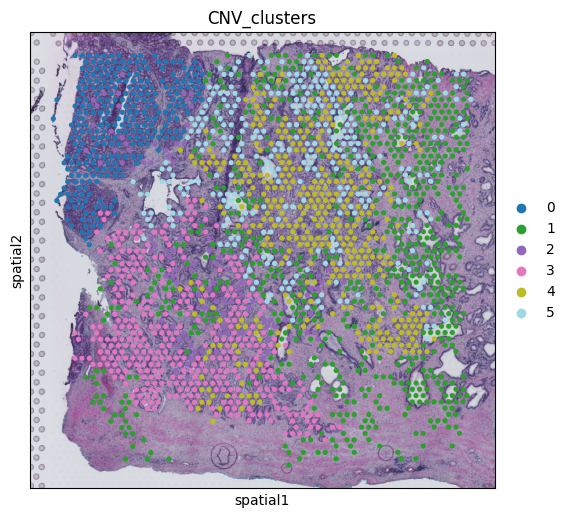

In [8]:
sc.pl.spatial(adata,
                # show first 8 cell types
                color=use_label,
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                palette = 'tab20')

In [9]:
root_cluster = '1' # The cluster that corresponds to the early stage of cancer (benign cells)

C:\Users\masmel\AppData\Local\anaconda3\envs\stlearn2\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr


All available trajectory paths are stored in adata.uns['available_paths'] with length < 6 nodes


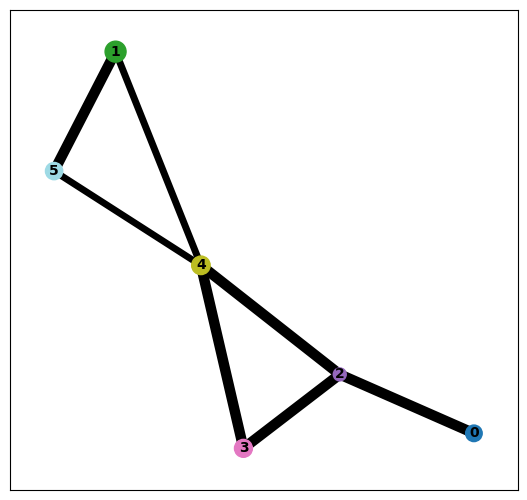

In [10]:
sc.tl.paga(adata, groups=use_label)
sc.pl.paga(adata, threshold=paga_threshold, show=False)
sc.tl.draw_graph(adata, init_pos="paga")

max_nodes = len(adata.obs[use_label].unique())

adata.uns["iroot"] = st.spatial.trajectory.set_root(adata,use_label=use_label,cluster=root_cluster)

H = pseudotime_new(adata, eps=eps, use_label = use_label, threshold = paga_threshold,
            reverse = False, max_nodes = max_nodes, threshold_spots = threshold_spots)
    

1_1_0
Screening PTS global graph...


Screening: 100%|██████████ [ time left: 00:00 ]


Calculate the graph dissimilarity using Laplacian matrix...


Calculating: 100%|██████████ [ time left: 00:00 ]


The optimized weighting is: 0.6
Start to construct the trajectory: 1 -> 5 -> 4 -> 2 -> 0


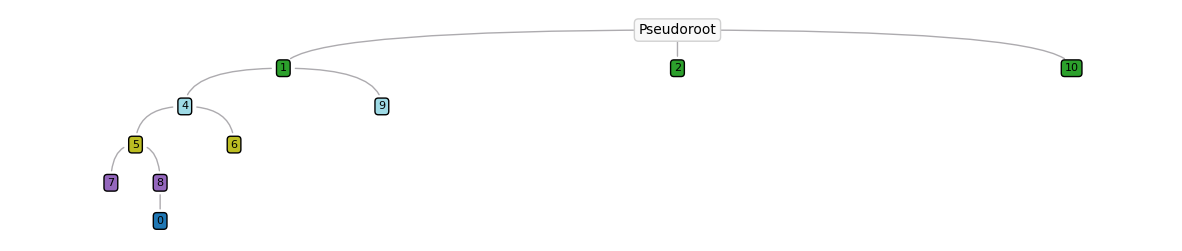

Detecting the transition markers of branch_9999_1_4_5_8_0
Transition markers result is stored in adata.uns['branch_9999_1_4_5_8_0']
Detecting the transition markers of branch_9999_2
Transition markers result is stored in adata.uns['branch_9999_2']
Detecting the transition markers of branch_9999_1_4_6
Transition markers result is stored in adata.uns['branch_9999_1_4_6']
Detecting the transition markers of branch_9999_1_4_5_7
Transition markers result is stored in adata.uns['branch_9999_1_4_5_7']
Detecting the transition markers of branch_9999_1_9
Transition markers result is stored in adata.uns['branch_9999_1_9']
Detecting the transition markers of branch_9999_10
Transition markers result is stored in adata.uns['branch_9999_10']
2_1_3
Screening PTS global graph...


Screening: 100%|██████████ [ time left: 00:00 ]


Calculate the graph dissimilarity using Laplacian matrix...


Calculating: 100%|██████████ [ time left: 00:00 ]


The optimized weighting is: 0.6
Start to construct the trajectory: 1 -> 5 -> 4 -> 2 -> 3


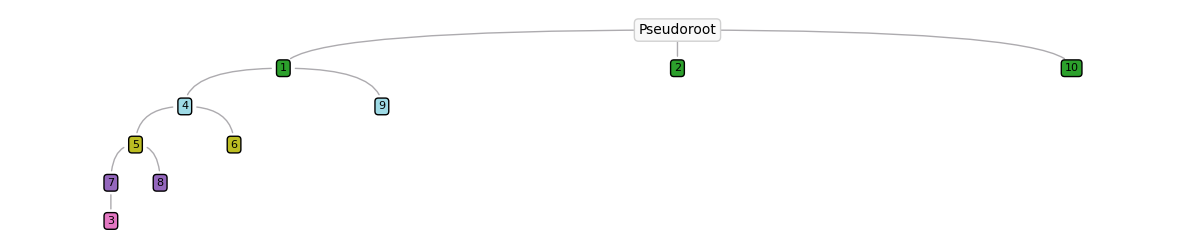

Detecting the transition markers of branch_9999_2
Transition markers result is stored in adata.uns['branch_9999_2']
Detecting the transition markers of branch_9999_1_4_5_7_3
Transition markers result is stored in adata.uns['branch_9999_1_4_5_7_3']
Detecting the transition markers of branch_9999_1_4_6
Transition markers result is stored in adata.uns['branch_9999_1_4_6']
Detecting the transition markers of branch_9999_1_4_5_8
Transition markers result is stored in adata.uns['branch_9999_1_4_5_8']
Detecting the transition markers of branch_9999_1_9
Transition markers result is stored in adata.uns['branch_9999_1_9']
Detecting the transition markers of branch_9999_10
Transition markers result is stored in adata.uns['branch_9999_10']


In [11]:
longest_paths = find_longest_paths_v2(adata)

for longest_path in longest_paths:

    print(longest_path)
    
    st.spatial.trajectory.pseudotimespace_global(adata,
                                                 use_label=use_label,
                                                 list_clusters=list(map(str, longest_paths[longest_path])),
                                                 use_rep = 'X_diffmap',
                                                 k = 10,
                                                 step = 0.1,
                                                 model = 'mixed')
    
        
    
    tree_plot_new(adata,piesize = 0, use_label = use_label, figsize = (15, 3), fontsize=8)
        
    G = _read_graph(adata, "PTS_graph")
    
    # Find and print all longest paths
    reasonable_paths = find_reasonable_paths(G)
    
    for path in reasonable_paths:
    
    
        st.spatial.trajectory.detect_transition_markers_branches(adata,branch=path,use_raw_count=False)

In [12]:
branch_summary = summarize_branch(adata, use_label, H)

In [13]:
gene_set = 'MSigDB_Hallmark_2020' #['MSigDB_Hallmark_2020'] 'GO_Biological_Process_2023','MSigDB_Hallmark_2020','KEGG_2021_Human' 
pathway_enrichment = enrichment_analysis(adata, gene_set)

up
branch_9999_1_4_5_8_0
branch_9999_1_4_6
branch_9999_1_4_5_7
branch_9999_1_9
branch_9999_1_4_5_7_3
branch_9999_1_4_5_8
down
branch_9999_1_4_5_8_0
branch_9999_1_4_6
branch_9999_1_4_5_7
branch_9999_1_9
branch_9999_1_4_5_7_3
branch_9999_1_4_5_8
abs
branch_9999_1_4_5_8_0
branch_9999_1_4_6
branch_9999_1_4_5_7
branch_9999_1_9
branch_9999_1_4_5_7_3
branch_9999_1_4_5_8


In [14]:
adata.uns['pathway_enrichment'] = pathway_enrichment

In [15]:
del adata.uns['split_node']
del adata.uns['global_graph']
del adata.uns['centroid_dict']
del adata.uns['PTS_graph']

In [16]:
adata.write_h5ad('hest_data/pseudotime/' + sample + '_pseudotime.h5ad')
branch_summary.to_csv('hest_data/pseudotime/'+ sample + '_branch_summary.csv')

### Old code to create the arrow plot and enrichment for one specific branch. Should be used after pseudotime_new function

In [ ]:
"""
list_clusters = ['3', '2', '1', '4', '6']

st.spatial.trajectory.pseudotimespace_global(adata,use_label="CNV_clusters",list_clusters=list_clusters,
                                                     use_rep = 'X_diffmap',
                                                     k = 10,
                                                     step = 0.1,
                                                     model = 'mixed')

adata.uns['spatial']['ST']['images']['hires'] = adata.uns['spatial']['ST']['images']['downscaled_fullres']
adata.uns['spatial']['ST']['scalefactors']['tissue_hires_scalef'] = adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef']


st.pl.cluster_plot(adata,use_label="CNV_clusters",show_trajectories=True,list_clusters=None,show_subcluster=False)

tree_plot_new(adata,piesize = 0, use_label = use_label, figsize = (15, 3), fontsize=8)

st.spatial.trajectory.detect_transition_markers_branches(adata,branch=['9999', '2', '4', '5', '0', '10'],use_raw_count=False)


adata.uns['branch_9999_2_4_5_0_10']
string_list = adata.uns['branch_9999_2_4_5_0_10'][adata.uns['branch_9999_2_4_5_0_10']['score'] > 0]['gene'].tolist()
enr_KEEG = gp.enrichr(gene_list=string_list,
                      gene_sets=gene_set,
                      #background=BG_genes,
                      organism='Human').results
summary = enr_KEEG[enr_KEEG['Adjusted P-value'] < 0.05][['Term','Odds Ratio','P-value', 'Adjusted P-value','Gene_set','Genes']]

from gseapy import barplot, dotplot
# categorical scatterplot
ax = barplot(enr_KEEG,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(3,5),
              #color=['darkred', 'darkblue'] # set colors for group
              #color = {'KEGG_2021_Human': 'salmon', 'MSigDB_Hallmark_2020':'darkblue'},
            title = 'positive association'
             )
"""